**"" Program Name : com_std & ini_th(no_motion)**  
**"" Programmer : Joo Icksoo**  
**"" Virsion No. : 21.04.09**  
**"" Revision Date : 21.04.09**  

In [61]:

import os
import sys

import matplotlib.pyplot as plt
import nidaqmx
import numpy as np
from IPython import display
from IPython.display import clear_output
from nidaqmx import constants
from pandas import DataFrame as df
from playsound import playsound
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

In [62]:
def Data_save(Frame_start, Frame_end, day, graph_on):
    global A_value
    global B_value
    global count

    A_temp = df(A_value[Frame_start - 1000:Frame_end + 1000])
    B_temp = df(B_value[Frame_start - 1000:Frame_end + 1000])

    path = day + '/'
    if not os.path.isdir(path):
        os.makedirs(path)
    diff = Frame_end - Frame_start

    data = []
    A_v = np.array(A_value[int(Frame_start - (diff * 0.1)):int(Frame_end + (diff * 0.1))])
    B_v = np.array(B_value[int(Frame_start - (diff * 0.1)):int(Frame_end + (diff * 0.1))])
    data.append(A_v.reshape(A_v.size))
    data.append(B_v.reshape(B_v.size))
    data.append((A_v - B_v).reshape(A_v.size))
    df(np.array(data).T).to_csv(path + 'Frame_{}.csv'.format(count), header=False, index=False)

    norm_data = []
    Nor_A, Nor_B, Nor_AB = Normalization(A_v, B_v)
    norm_data.append(Nor_A.reshape(Nor_A.size))
    norm_data.append(Nor_B.reshape(Nor_B.size))
    norm_data.append(Nor_AB.reshape(Nor_AB.size))

    if not os.path.isdir(path + 'Normalization/'):
        os.makedirs(path + 'Normalization/')
    df(np.array(norm_data).T).to_csv(path + 'Normalization/' + 'Norm_Frame_{}.csv'.format(count), header=False,
                                     index=False)

    clear_output(wait=True)
    if graph_on == 1:
        Graph_drawing(norm_data, diff)

In [63]:
def Graph_drawing(norm_data, diff):
    fig = plt.figure(figsize=(9, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.plot(norm_data[0], label='A', c='r')
    ax1.plot(norm_data[1], label='B', c='b')
    ax1.legend(loc='upper right')
    ax2.plot(norm_data[2], c='black')
    display.display(fig)
    plt.clf()

    print("동작의 길이는 %.3f초 입니다." % (diff / 1000))

In [64]:
def Normalization(A, B):
    """
    한 프레임의 센서 신호 데이터를 A,B센서에서 입력받아 정규화하고 정규화한 데이터를 반환한다.
    """
    min_max_scaler = MinMaxScaler()
    A_B = A - B
    temp = len(A) % 100
    len_compare = len(A) - temp

    div_len = 0

    Norm_A = []
    Norm_B = []
    Norm_AB = []

    if (len_compare > 1000):  # 프레임 길이 센서 A, B 모두 1000을 넘을 때 
        div_len = 1000 / len_compare

    else:
        div_len = len_compare / 1000

    for k in range(1000):
        Norm_A.append(A[int(k * div_len)])
        Norm_B.append(B[int(k * div_len)])
        Norm_AB.append(A_B[int(k * div_len)])

    Norm_A = df(Norm_A)
    Norm_A = Norm_A.interpolate(method='values')
    Norm_A = min_max_scaler.fit_transform(Norm_A)

    Norm_B = df(Norm_B)
    Norm_B = Norm_B.interpolate(method='values')
    Norm_B = min_max_scaler.fit_transform(Norm_B)

    Norm_AB = df(Norm_AB)
    Norm_AB = Norm_AB.interpolate(method='values')
    Norm_AB = min_max_scaler.fit_transform(Norm_AB)

    Norm_A = np.array(Norm_A)
    Norm_B = np.array(Norm_B)
    Norm_AB = np.array(Norm_AB)

    return Norm_A, Norm_B, Norm_AB

In [65]:
def daq_sensor(sfreq):
    global stop
    inc = 0
    data = [[], []]
    A_value = []
    B_value = []
    with nidaqmx.Task() as task:
        task.__init__(new_task_name='EPS Signal')
        ch_A = task.ai_channels.add_ai_voltage_chan("Dev1/ai5", max_val=10, min_val=-10)
        ch_B = task.ai_channels.add_ai_voltage_chan("Dev1/ai2", max_val=10, min_val=-10)

        ch_A.ai_term_cfg = nidaqmx.constants.TerminalConfiguration.RSE
        ch_B.ai_term_cfg = nidaqmx.constants.TerminalConfiguration.RSE

        task.timing.cfg_samp_clk_timing(rate=sfreq, sample_mode=constants.AcquisitionType.CONTINUOUS)
        sos = signal.butter(3, 10, 'lp', fs=1000, output='sos')

        # 데이터 변수에 저장, 필터 적용, MA 적용, 
        while True:
            if (inc == 0):
                temp = task.read(number_of_samples_per_channel=2000)
            elif (inc > 0):
                temp = task.read(number_of_samples_per_channel=1000)

            data[0] = data[0] + temp[0]
            data[1] = data[1] + temp[1]

            filtered_A = signal.sosfilt(sos, data[0][(1000 * inc):(1000 * inc) + 2000])
            filtered_B = signal.sosfilt(sos, data[1][(1000 * inc):(1000 * inc) + 2000])

            filtered_A = df(np.transpose(np.array(filtered_A)))
            filtered_B = df(np.transpose(np.array(filtered_B)))

            MA_A = filtered_A.rolling(50).mean()
            MA_B = filtered_B.rolling(50).mean()

            MA_A = list(np.array(MA_A[0].tolist()))
            MA_B = list(np.array(MA_B[0].tolist()))

            for loops in range(49):
                MA_A[loops] = np.mean(MA_A[49:99])
                MA_B[loops] = np.mean(MA_B[49:99])

            for te in range(1000, 2000):
                A_value.append(MA_A[te])
                B_value.append(MA_B[te])
            global A
            global B
            A = A_value
            B = B_value
            inc = inc + 1  #중요!!!!

            if stop == 1:
                break

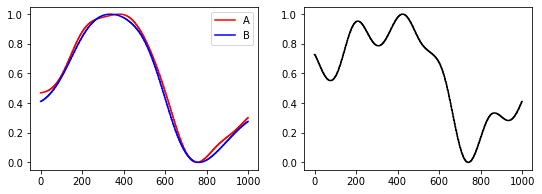

동작의 길이는 0.257초 입니다.
동작 3회 완료
1을 입력하면 종료, 0을 입력하면 계속 >> 1


<Figure size 648x216 with 0 Axes>

<Figure size 648x216 with 0 Axes>

<Figure size 648x216 with 0 Axes>

In [58]:
mod = sys.modules[__name__]
%matplotlib inline

# 반복검사 여부 확인
repeat = int(input('프레임 검사 반복 여부를 확인하시겠습니까?(확인할 경우 1을, 아닐경우 0을 입력하세요)\n >> ')
# 그래프 실행여부 확인
graph_on = int(input('그래프를 표시하시겠습니까?(표시할 경우 1을, 아닐경우 0을 입력하세요)\n >> '))

day = datetime.today().strftime("%Y.%m.%d %H시 %M분 %S초")
Initial_threshold = 0.022
interval_period = 1.0
human_list = ['JSI', 'KB', 'CJW', 'KME', 'KJY', 'PJS']
motion_list = ['Mo type 1. LR', 'Mo type 2. RL', 'Mo type 3. CW', 'Mo type 4. CCW', 'Mo type 5. GH', 'Mo type 6. SH',
               'Mo type 7. RH', 'Mo type 8. DH']

# ------------------------- 입력 변수 시작 ----------------------------- #
Initial_threshold = float(input("초기 문턱치를 입력하세요 : "))

print("실험자 목록")
for i in range(len(human_list)):
    print('{}. {}'.format(i, human_list[i]))
human = input("실험자의 번호를 입력하세요. >> ".format(human_list))
print()

print("동작종류 목록")
for i in range(len(motion_list)):
    print('{}. {}'.format(i, motion_list[i]))
motion = input("실험할 동작종류 번호를 입력하세요. >> ".format(motion_list))
print()

limit = 0
limit = int(input("실험할 동작 횟수를 입력하세요 (무제한으로 하시려면 0을 입력하세요) : "))

interval_period = float(input("동작이 발생한 후 다음 동작까지의 간격을 초 단위로 입력하세요 : "))
# ------------------------- 입력 변수 끝 ------------------------------ #

# ------------------------- 변수 초기화 ------------------------------- #
start = 0
Motion_occur = 0
Frame_start = 0
Frame_end = 0
sfreq = 1000
interval = 5000
count = 0
check = 0
A = []
B = []
index = 0

start = time.time()
print("동작 실험을 시작합니다. 대기해 주세요")
playsound("start.mp3")
flag_1 = 0

stop = 0
t = threading.Thread(target=daq_sensor, args=(sfreq,))
t.daemon = True
t.start()

while True:
    # DAQ 신호가 갱신되면 다음 루프를 검사
    if index * 1000 < len(A) and index * 1000 < len(B):
        A_value = A
        B_value = B
    else:
        continue

    # 입력받은 종료 플래그에 해당하면 종료
    if flag_1 == 1:
        break

    for num in range(index * 1000, index * 1000 + 1000):
        if interval > num:
            continue
        if count == 0 and start == 0:
            print("실험을 시작합니다.")
            playsound("first.mp3")
            start = 1
        # ---------------------------- 동작 종료 후 처리 ----------------------------- #
        if Motion_occur == 1:
            Data_save(Frame_start, Frame_end, day, graph_on)
            Motion_occur = 0
            count += 1
            print('동작 {}회 완료'.format(count))
            # 지정한 동작 횟수가 끝나면 종료
            if count == limit:
                flag_1 = 1
                playsound("end.mp3")
                stop = 1
                break
            # 입력에 따라 종료
            if repeat == 1:
                flag_1 = int(input("1을 입력하면 종료, 0을 입력하면 계속 >> "))
            else:
                flag_1 = 0
            if flag_1 == 1:
                playsound("end.mp3")
                stop = 1
                break
            else:
                stop = 0
                index = (len(A) // 1000) + 1
                playsound("next.mp3")
            Frame_start = 0
            Frame_end = 0
        # ---------------------------- 동작 감지 알고리즘 --------------------------- #
        if (Frame_start == 0):
            A_mean = np.mean(A_value[num - 799:num - 300])
            B_mean = np.mean(B_value[num - 799:num - 300])

            A_threshold_up = A_mean + float(Initial_threshold)
            A_threshold_down = A_mean - float(Initial_threshold)
            B_threshold_up = B_mean + float(Initial_threshold)
            B_threshold_down = B_mean - float(Initial_threshold)

        if ((A_value[num] > A_threshold_up) or
                (A_value[num] < A_threshold_down)):

            if (Frame_start == 0):
                Frame_start = num

            elif (Frame_start != 0):
                Frame_end = num

        if ((B_value[num] > B_threshold_up) or
                (B_value[num] < B_threshold_down)):

            if (Frame_start == 0):
                Frame_start = num

            elif (Frame_start != 0):
                Frame_end = num

        if Frame_start == 0:
            continue
        if Frame_start == num:
            print("동작 프레임 계산중입니다.")
        #------------------------------ 한 동작 프레임 종료 ------------------------------------ #
        if (num == Frame_start + 3000):
            Motion_occur = 1
            interval = num + int(interval_period * 1000)
    #             interval = num + (int(random.random()*5000 + 2000))

    index += 1

# ----------------------------- 전체 신호 저장 ----------------------------------------- #
if not os.path.isdir(day + '/'):
    os.makedirs(day + '/')
df(A_value).to_csv(day + '/data_A.csv', header=False, index=False)
df(B_value).to_csv(day + '/data_B.csv', header=False, index=False)

In [59]:
# 스레드 초기화용, 코드를 비정상 종료했을 경우 실행
stop = 1